In [ ]:
# %pip install pandas numpy seaborn matplotlib scikit-learn sentence-transformers

### Importing Libraries ###

In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import clean_data
import matplotlib.pyplot as plt
import nltk

### Loading & Inspecting Data ###


In [4]:
# Loading Data
delta_df = pd.read_csv("datasets/Delta_Airline_Review_Dataset-Asof02172023.csv")
display(delta_df.head())

# Inspecting Data
print("----Data Info----\n")
print(delta_df.info())

print("\n----Data Shape----\n")
print(f'delta_df.shape: {delta_df.shape}')

print("\n----Data Stats----\n")
print(delta_df.describe())

print("\n----Data Null----\n")
print(delta_df.isnull().sum())


----Data Info----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer_ID     2689 non-null   int64 
 1   star rating     2689 non-null   int64 
 2   date            2689 non-null   object
 3    Seat Type      2689 non-null   object
 4   routes          2263 non-null   object
 5   traveler_types  2282 non-null   object
 6   country         2689 non-null   object
 7   reviews         2689 non-null   object
dtypes: int64(2), object(6)
memory usage: 168.2+ KB
None

----Data Shape----

delta_df.shape: (2689, 8)

----Data Stats----

       Customer_ID  star rating
count  2689.000000  2689.000000
mean   1345.000000     3.860915
std     776.391761     3.462060
min       1.000000     0.000000
25%     673.000000     1.000000
50%    1345.000000     2.000000
75%    2017.000000     8.000000
max    2689.000000    10.000000

----Data Null----

Cu

### Cleaning Data ###

In [12]:
cleaned_delta_df = clean_data(delta_df)
print(f'cleaned_delta_df.shape: {cleaned_delta_df.shape}')
display(cleaned_delta_df.head())

----Data Cleaned----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Customer_ID     2689 non-null   int64         
 1   star rating     2689 non-null   int64         
 2   date            2689 non-null   datetime64[ns]
 3    Seat Type      2689 non-null   object        
 4   routes          2689 non-null   object        
 5   traveler_types  2689 non-null   object        
 6   country         2689 non-null   object        
 7   reviews         2689 non-null   object        
 8   sentiment       2689 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 170.9+ KB
None

Null values:
 Customer_ID       0
star rating       0
date              0
 Seat Type        0
routes            0
traveler_types    0
country           0
reviews           0
sentiment         0
dtype: int64

Se

,Customer_ID,star rating,date,Seat Type,routes,traveler_types,country,reviews,sentiment
0,1,4,2023-02-17,economy class,new york to tel aviv,solo leisure,united states,"first, travel starts 6pm arrival at the air...",Positive
1,2,1,2023-02-16,economy class,milwaukee to ft lauderdale,business,united states,delta did not issue any weather waivers so ...,Negative
2,3,1,2023-02-10,economy class,new york to charlotte,business,united states,"per our pilot, there would be a slight dela...",Negative
3,4,1,2023-02-08,premium economy,atlanta to cape town,family leisure,united states,we flew from atlanta to cape town and back ...,Negative
4,5,2,2023-02-06,economy class,dallas to atlanta,solo leisure,united kingdom,"checkin staff always seem unfriendly, no ma...",Negative


### Preliminary Visualization ###

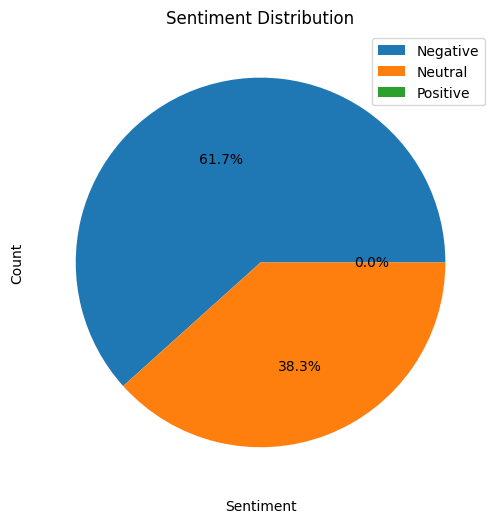

In [19]:
# Data description distribution
plt.figure(figsize=(10, 6))

plt.pie(cleaned_delta_df['sentiment'].value_counts(), autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
labels = ['Negative', 'Neutral', 'Positive']
plt.legend(labels)
plt.show()


### Preprocessing Data ###

In [ ]:
### Using Sentence Transformers to tokenize text
def sentence_tokenize_text(text):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(text)
    return embeddings

# cleaned_delta_df['embedding'] = cleaned_delta_df['reviews'].apply(sentence_tokenize_text)

In [54]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download all required NLTK resources
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# Initialize tools
wn = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add any additional stopwords you want to remove
additional_stops = {'to', 'the', 'and', 'a', 'an', 'in', 'on', 'at', 'for', 'of', 'with', 'delta'}
stop_words.update(additional_stops)

def process_text(text):
    try:
        # Convert to string if not already
        text = str(text)
        
        # Simple word tokenization (split by whitespace)
        tokens = text.split()
        
        # Convert to lowercase
        tokens = [word.lower() for word in tokens]
        
        # Remove stopwords and non-alphabetic tokens
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        
        # Lemmatize
        tokens = [wn.lemmatize(word) for word in tokens]
        
        # Join back into text
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""  # Return empty string on error

# Process reviews
cleaned_delta_df['processed_reviews'] = cleaned_delta_df['reviews'].apply(process_text)

# Now use TF-IDF on the processed reviews
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(cleaned_delta_df['processed_reviews'])

[nltk_data] Downloading package punkt to /Users/godwins/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/godwins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/godwins/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/godwins/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Model Training ###

In [55]:
### Features and target for sentence transformers
# X = np.array(cleaned_delta_df['embedding'].tolist())
# y = cleaned_delta_df['sentiment'].values

### Features and target for TF-IDF
# Get feature names
feature_names = vectorizer.get_feature_names_out()
# Convert to array for the model
# X = X.toarray()
y = cleaned_delta_df['sentiment'].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}")

Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.87      0.73       331
    Positive       0.43      0.15      0.23       207

    accuracy                           0.59       538
   macro avg       0.52      0.51      0.48       538
weighted avg       0.55      0.59      0.53       538



### Fine Tuning Model ###

In [62]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train)
print_results(cv)

BEST PARAMS: {'max_depth': 10, 'n_estimators': 50}

0.61 (+/-0.006) for {'max_depth': 2, 'n_estimators': 5}
0.617 (+/-0.002) for {'max_depth': 2, 'n_estimators': 50}
0.617 (+/-0.002) for {'max_depth': 2, 'n_estimators': 100}
0.592 (+/-0.028) for {'max_depth': 10, 'n_estimators': 5}
0.628 (+/-0.016) for {'max_depth': 10, 'n_estimators': 50}
0.62 (+/-0.008) for {'max_depth': 10, 'n_estimators': 100}
0.581 (+/-0.032) for {'max_depth': 20, 'n_estimators': 5}
0.618 (+/-0.023) for {'max_depth': 20, 'n_estimators': 50}
0.624 (+/-0.025) for {'max_depth': 20, 'n_estimators': 100}
0.561 (+/-0.038) for {'max_depth': None, 'n_estimators': 5}
0.609 (+/-0.011) for {'max_depth': None, 'n_estimators': 50}
0.612 (+/-0.02) for {'max_depth': None, 'n_estimators': 100}


In [63]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
model.fit(X_train,y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}")

Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.95      0.75       331
    Positive       0.50      0.08      0.13       207

    accuracy                           0.62       538
   macro avg       0.56      0.51      0.44       538
weighted avg       0.58      0.62      0.51       538



### Visualizing Model ###

In [64]:
def plot_feature_importance(model,feature_names, n_features=10, figsize=(10,6)):
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot top n_features
    plt.figure(figsize=figsize)
    plt.title('Top Feature Importances in Sentiment Analysis')
    
    # Plot only top n_features
    n = min(n_features, len(importances))
    plt.bar(range(n), 
            importances[indices][:n],
            align='center')
    
    # Use actual words as labels
    plt.xticks(range(n), 
               [feature_names[i] for i in indices[:n]], 
               rotation=45,
               ha='right')
    
    plt.xlabel('Words')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

def plot_decision_tree(model, max_depth=3, figsize=(20,10)):
    plt.figure(figsize=figsize)
    # Get a single tree from the forest
    tree = model.estimators_[0]
    
    # Create feature names for all dimensions
    feature_names = [f'dim_{i}' for i in range(model.n_features_in_)]
    
    plot_tree(tree, 
             feature_names=feature_names,
             max_depth=max_depth,
             filled=True,
             rounded=True)
    plt.show()

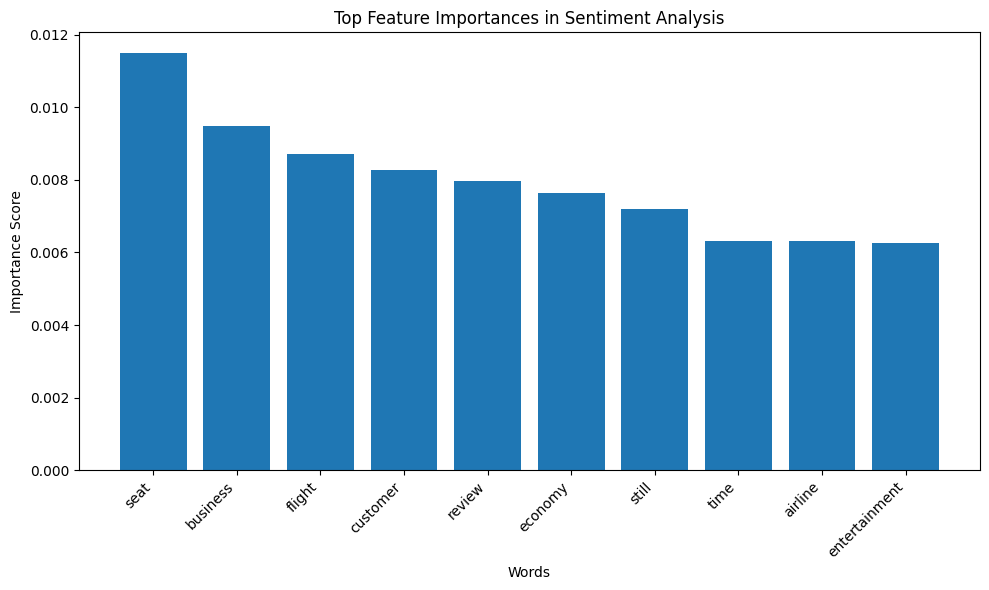

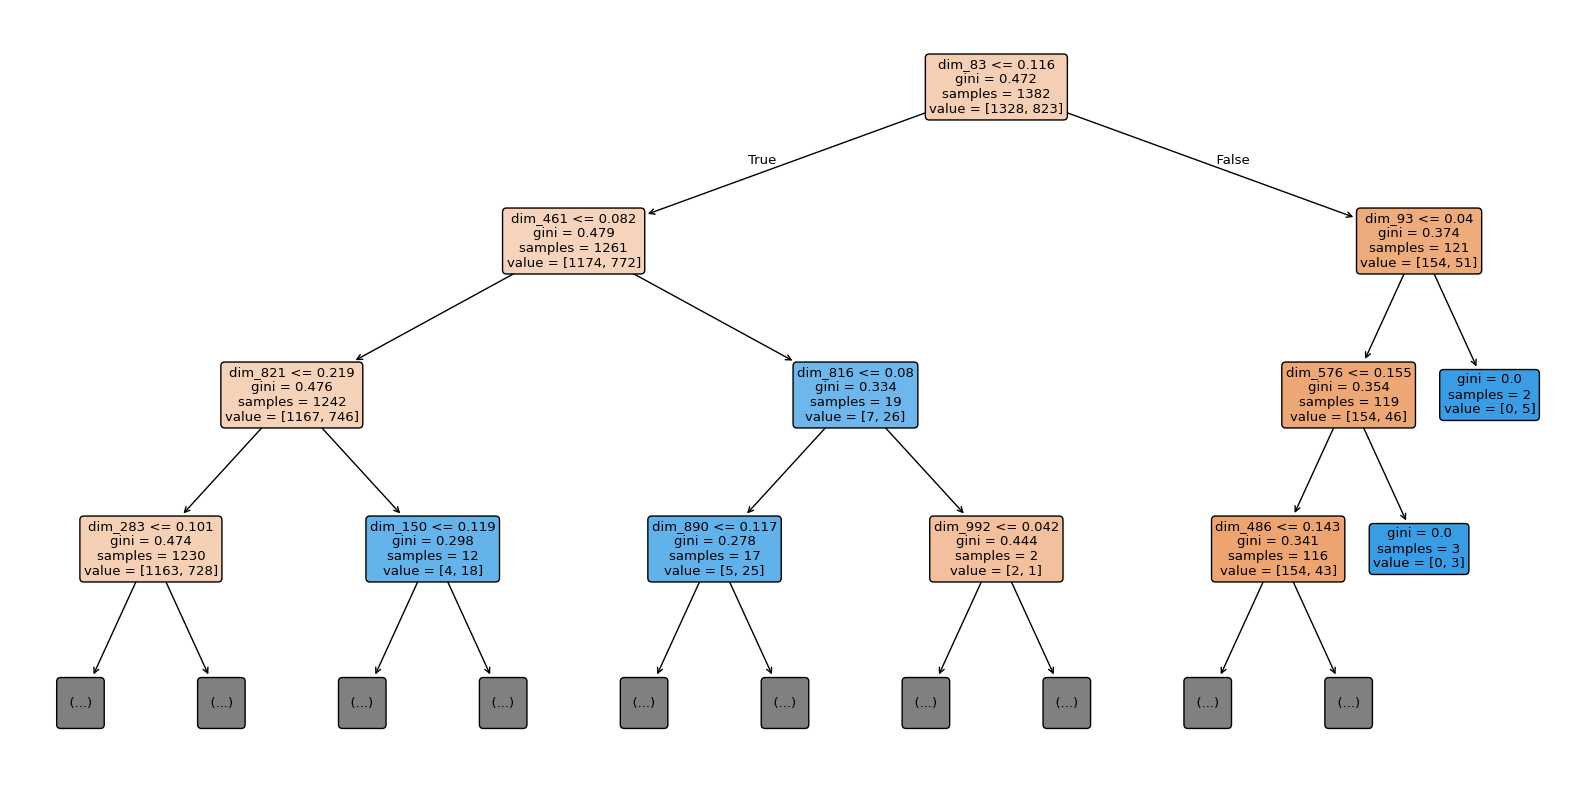

In [65]:
# Visualize feature importance (top 10 features)
plot_feature_importance(
    model=model,
    feature_names=feature_names
)

# Visualize a single tree from the forest
plot_decision_tree(
    model=model,
    max_depth=3
)